# Narzędzie wizualizujące tworzenie grafu widoczności

## Konfiguracja


Poniższe narzędzie zostało zmodyfikowane, tak aby można było z niego korzystać w nowszych IDE, które nie wspierają `%matplotlib notebook`.
Aby korzystać z `%matplotlib widget` należy doinstalować pakiet `ipympl` np. za pomocą polecenia `pip install ipympl`. Jeżeli po zainstalowaniu będą występować błędy, należy korzystać z backendu `notebook`.

Wykorzystywane biblioteki:
- matplotlib
- numpy
- ipympl
- sortedcontainers

Nowe funkcje:
- Dodanie do konstruktora klasy Scene argumentu `title`, który pozwala na ustawienie tytułu danej sceny
- Dodanie do konstruktora klasy Plot argumentu `title`, który pozwala na ustawienie tytułu wykresu / okna widżetu
- Dodanie możliwości definiowania własnych zakresów osi OX oraz OY dla wykresów (argumenty klasy Plot: `xlim` oraz `ylim` jako krotka dwuelementowa definiująca przedział, gdy zostanie podany tylko zakres dla jednej osi, druga oś będzie automatycznie skalowana)

Naprawione bugi:
- Naprawiono problem, gdy po utworzeniu nowego pustego wykresu, tworzyła się kopia poprzednio utworzonego (kopiowały się sceny z ostatniego obiektu plot)
- Poprawiono metodę zamykania figur (tworzony jest okrąg o środku pierwszego punktu i promieniu adekwatnym do zakresów osi)
- Nowo dodane figury, punkty, linie są zapisywane osobno dla każdej sceny
- Zmieniono wyświetlanie się punktów i linii (punkty wyświetlają się przed liniami)


In [106]:
# Wybór backendu matplotlib
%matplotlib notebook
# %matplotlib widget


# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.02

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes, xlim=[], ylim=[]):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = [[] for _ in range(len(scenes))]
        self.adding_lines = False
        self.added_lines = [[] for _ in range(len(scenes))]
        self.adding_rects = False
        self.added_rects = [[] for _ in range(len(scenes))]
        # DODANO: zapisz tytuł sceny
        self.scene_title = self.scenes[0].title if len(self.scenes) and self.scenes[0].title else ""
        # DODANO: ustawienie zakresów osi wykresu
        self.xlim = xlim
        self.ylim = ylim
        self.custom_axis = len(xlim) != 0 or len(ylim) != 0

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        # ADDED: Change scene title
        self.scene_title = self.scenes[self.i].title
        self.draw(autoscaling = not self.custom_axis)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        # ADDED: Change scene title
        self.scene_title = self.scenes[self.i].title
        self.draw(autoscaling = not self.custom_axis)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points[self.i].append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines[self.i].append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects[self.i].append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        return self.added_points[self.i]
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        return self.added_lines[self.i]
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        return self.added_rects[self.i]
  
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        return Scene(self.added_points[self.i], self.added_lines[self.i]+self.added_rects[self.i])


    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[self.i][-1].add_points([new_point])
            self.draw(autoscaling = False,hand_drawing=True)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[self.i][-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False,hand_drawing=True)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[self.i][-1].add((self.rect_points[-1], new_point))
                self.rect_points.append(new_point)
                self.draw(autoscaling = False,hand_drawing=True)
            elif len(self.rect_points) > 1:
                # DODANO: zmiana metody wykrywania zakończenia figury.
                # Teraz punkt self.rect_points[0] jest środkiem okręgu o promieniu TOLERANCE*(mediana zakresów wykresu)
                # Gdy użytkownik kliknie w obrębie tego okręgu, figura zostanie zamknięta
                if (new_point[0] - self.rect_points[0][0]) ** 2 + (new_point[1] - self.rect_points[0][1]) ** 2 <= (np.mean([self.ax.get_xlim()[1] - self.ax.get_xlim()[0], self.ax.get_ylim()[1]-self.ax.get_ylim()[0]])*TOLERANCE) ** 2:
                    self.added_rects[self.i][-1].add((self.rect_points[-1], self.rect_points[0]))
                    self.new_rect()
                else:    
                    self.added_rects[self.i][-1].add((self.rect_points[-1], new_point))
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False, hand_drawing=True)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True, hand_drawing = False):
        # DODANO: ustawienie zakresów osi wykresu
        autoscale_axis='both'
        if not autoscaling:
            if self.custom_axis:
                xlim = self.xlim  
                ylim = self.ylim  

            choose_autoscale_axis = [False, False] # [OX, OY]

            if not self.custom_axis or not self.xlim:
                xlim = self.ax.get_xlim()
                choose_autoscale_axis[0] = True
            
            if not self.custom_axis or not self.ylim:
                ylim = self.ax.get_ylim()
                choose_autoscale_axis[1] = True

            if choose_autoscale_axis == [True, False]:
                autoscale_axis = 'x'
                autoscaling = not hand_drawing
            if choose_autoscale_axis == [False, True]:
                autoscale_axis = 'y'
                autoscaling = not hand_drawing

        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points[self.i]):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs, zorder=3)
        for collection in (self.scenes[self.i].lines + self.added_lines[self.i] + self.added_rects[self.i]):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(enable=autoscaling, axis=autoscale_axis)

        if autoscale_axis == 'y':
            self.ax.set_xlim(xlim)

        if autoscale_axis == 'x':
            self.ax.set_ylim(ylim)
      
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
            
        # DODANO: tytuł sceny
        fig = plt.gcf() # Pobierz aktywne okno
        fig.suptitle(self.scene_title)
        
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [107]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[], title=""):
        self.points=points
        self.lines=lines
        # ADDED: Scene title
        self.title = '\n'+title if title != "" else ""

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [], points = [], lines = [], json = None, title="", xlim=[], ylim=[]):
        # DODANO: tytuł wykresu
        self.plot_title = title
        # DODANO: ustawienie zakresów osi wykresu
        self.xlim = xlim
        self.ylim = ylim
        self.is_not_custom_axis = len(xlim)==0 and len(ylim)==0

        # NAPRAWIONO: pobieranie scen z wcześniej utworzonego wykresu
        if not scenes:
            self.scenes = [Scene()]
        else:
            self.scenes = scenes

        if json is None:
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]], title=scene["title"]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines],
                          "title": scene.title[1:]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            result = self.callback.get_added_points()
            return result
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            result = self.callback.get_added_lines()
            return result

    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            result = self.callback.get_added_figure()
            return result

    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            result = self.callback.get_added_elements()
            return result

    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        # DODANO: tytuł wykresu
        fig = plt.figure(num=self.plot_title)
        # DODANO: ustawienie zakresów osi wykresu
        self.callback = _Button_callback(self.scenes, self.xlim, self.ylim)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        # DODANO: ustawienie zakresów osi wykresu
        self.callback.draw(self.is_not_custom_axis)
        

### Przykłady użycia

##### Proste rysowanie

Rysowanie prostego rysunku złożonego ze statycznych punktów i odcinków jest stosunkowo proste. Należy utworzyć zmienną z obiektem `Plot`, który przyjmuje w konstruktorze listę obiektów `PointsCollection` jako parametr `points` oraz listę `LinesCollection` jako parametr `lines`. Następnie należy wywołać jego metodę `draw()`.

```python
plot = Plot(points=[PointsCollection([(1, 2), (3, 1.5), (2, -1)]),
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")],
            lines=[LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])])
plot.draw()     
```

##### Rysunek dynamiczny

To narzędzie pozwala na wizualizację "rysunków dynamicznych", a więc takich, które składają się z wielu różnych obrazów. Może to być przydatne np. podczas wizualizacji kolejnych kroków danego algorytmu. Poszczególne klatki określane są jako obiekty `Scene`, które przyjmują listę `PointsCollection` oraz listę `LinesCollection` w swoim konstruktorze. Obiekt `Plot` przyjmuje w parametrze konstruktora `scenes` właśnie listę takich scen.

Na rysunku przyciski `Następny` i `Poprzedni` służą do nawigacji pomiędzy nimi.

```python
scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])], "Scene 1"), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])],"Scene 2")]

plot=Plot(scenes = scenes)
plot.draw()
```

##### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

```python
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.json: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()
```

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

```python 
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot(points=[PointsCollection([(-2,-1),(5,3)], color='red')])
plot1.draw()

plot2 = Plot([plot1.get_added_elements()])
plot2.draw()
```

## Dodatkowe biblioteki oraz funkcje

In [108]:
from functools import cmp_to_key
from math import sqrt
from sortedcontainers import SortedSet
from queue import PriorityQueue

def euclidean_distance(a: tuple[float,float],b: tuple[float,float]) -> float:
    """Calculate distance between point a and point b using Euclidean metric.

    :param tuple[float,float] a: First point
    :param tuple[float,float] b: Second point
    :return float: Distance between a and b
    """

    return np.linalg.norm(np.array(a[0] - b[0], a[1] - b[1]))

def point_position(a: tuple[float,float], b:tuple[float,float], c:tuple[float,float], epsilon=1e-10) -> int:
    """Find position of a point c relative to segment ab using 3x3 matrix determinant. 

    :param tuple[float,float] a: First point of a segment/vector
    :param tuple[float,float] b: Second point of a segment/vector
    :param tuple[float,float] c: Point which is considered
    "param float epsilon: Tolerance for collinearity
    :return int: 1 if point lies on the left, 0 if is collinear, -1 if is on the right side of a segment ab.
    """

    # Calculate matrix
    matrix = [[],[],[]]
    matrix[0] = [a[0], a[1], 1]
    matrix[1] = [b[0], b[1], 1]
    matrix[2] = [c[0], c[1], 1]

    f1 = matrix[0][0] * matrix[1][1] * matrix[2][2]
    f2 = matrix[0][1] * matrix[1][2] * matrix[2][0]
    f3 = matrix[1][0] * matrix[2][1] * matrix[0][2]
    f4 = matrix[0][2] * matrix[1][1] * matrix[2][0]
    f5 = matrix[1][2] * matrix[2][1] * matrix[0][0]
    f6 = matrix[1][0] * matrix[0][1] * matrix[2][2]
    
    determinant = f1+f2+f3-f4-f5-f6

    # Return relative position

    # Point c is on the left side of segment ab
    if determinant > epsilon:
        return 1
    # Point c is collinear with segment ab
    elif -epsilon <= determinant <= epsilon:
        return 0
    # Point c is on the right side of segment ab
    else:
        return -1

## Terminologia

- $p$ - punkt aktualnie badany
- $w_i$ - punkt, który może być widoczny przez punkt $p$

## Założenia
- punkty startowe i końcowe nie leżą w żadnym wnętrzu przeszkody
- wszystkie przeszkody są zadawane w kierunku przeciwnym do wskazówek zegara

## Algorytm sprawdzania, czy punkt $w_i$ jest widoczny przez $p$

In [109]:
def do_two_segment_intersect(segment1: tuple[tuple[float,float],tuple[float,float]], segment2: tuple[tuple[float,float], tuple[float,float]]) -> bool:
    """Algorithm for checking whether two segment intersect. 
    General case: For first segment: second segment has to have it's points on different sides of first segment (one on the left and one on the right), same condition must fulfill second segment, relative to fist segment. 
    Special case: When segments are collinear, then we have to check their x and y projections on axis.

    :param tuple[tuple[float,float],tuple[float,float]] segment1: First segment
    :param tuple[tuple[float,float], tuple[float,float]] segment_2: Second segment
    :return bool: True, if two segments intersect
    """
  
    # First segment
    first_segment_result = [point_position(segment1[0], segment1[1], segment2[0]),point_position(segment1[0], segment1[1], segment2[1])]
    # Sort results
    if first_segment_result[0] > first_segment_result[1]:
        first_segment_result = first_segment_result[::-1]

    # Second segment 
    second_segment_result = [point_position(segment2[0], segment2[1], segment1[0]),point_position(segment2[0], segment2[1], segment1[1])]
    # Sort results
    if second_segment_result[0] > second_segment_result[1]:
        second_segment_result = second_segment_result[::-1]

    # General case
    if first_segment_result == [-1, 1] and second_segment_result == [-1,1]:
        return True

    # Special case
    if first_segment_result == [0,0] and second_segment_result == [0,0]:
        # Check x projection
        max_x_segment1 = max(segment1, key=lambda x: x[0])[0]
        min_x_segment1 = min(segment1, key=lambda x: x[0])[0]
        min_x_segment2 = min(segment2, key=lambda x: x[0])[0]
        max_x_segment2 = max(segment2, key=lambda x: x[0])[0]
        if max_x_segment1 < min_x_segment2 or max_x_segment2 < min_x_segment1:
            return False
        
        # Check y projection
        max_y_segment1 = max(segment1, key=lambda x: x[1])[1]
        min_y_segment1 = min(segment1, key=lambda x: x[1])[1]
        min_y_segment2 = min(segment2, key=lambda x: x[1])[1]
        max_y_segment2 = max(segment2, key=lambda x: x[1])[1]
        if max_y_segment1 < min_y_segment2 or max_y_segment2 < min_y_segment1:
            return False
        
        return True

    return False
    

def visible(p: tuple[float,float], i:int, w: list[tuple[float,float]], S:list[SortedSet[tuple[tuple[float,float], tuple[float,float]]]], S_as_graph: dict[tuple[float,float], tuple[float,float]], T: SortedSet, W: set, S_points: list[SortedSet[tuple[float, float]]]) -> bool:
    """Check if segment pw[i] doesn't intersect any obstacle.

    :param tuple[float,float] p: point of origin
    :param int i: index of point to see
    :param list[tuple[float,float]] w: point to be seen by point p
    :param list[SortedSet[tuple[tuple[float,float], tuple[float,float]]]] S: List of figures represented as SortedSet of edges
    :param dict[tuple[float,float], tuple[float,float]] S_as_graph: Adjacency dict of vertices in S
    :param SortedSet T: Intersected edges by half-line
    :param set W: Visible points
    :param list[SortedSet[tuple[float, float]]] S_points: List of figure points
    :return bool: True, if point w[i] is visible by p
    """

    # Check if segment pw[i] is an edge of obstacle
    if w[i] in S_as_graph[p] and p in S_as_graph[w[i]]:
        return True

    # Check if segment pw[i] intersects the interior of the obstacle of which w[i] is a vertex

    # Get figure
    fig = None
    for j in range(len(S_points)):
        if p in S_points[j] and w[i] in S_points[j]:
            fig = S_points[j]
            break

    # Get indexes of p and w[i]
    if fig != None:
        p_index = fig.index(p)
        wi_index = fig.index(w[i])
        p_next_index = (p_index + 1)%len(fig)
        p_prev_index = (p_index - 1)%len(fig)

        v1 = (fig[p_next_index][0] - fig[p_index][0], fig[p_next_index][1] - fig[p_index][1])
        v2 = (fig[p_prev_index][0] - fig[p_index][0], fig[p_prev_index][1] - fig[p_index][1])
        v3 = (fig[wi_index][0] - fig[p_index][0], fig[wi_index][1] - fig[p_index][1])

        # Calculate sin angles from cross product (we can assume, that vectors have z coordinate equal to 0)
        crossProducts = [v1[0]*v2[1]-v1[1]*v2[0], v1[0]*v3[1] - v1[1]*v3[0], v3[0]*v2[1] - v3[1]*v2[0]]

        # If value of cross product is >= 0, then counter-clockwise angle between vectors (v_x, v_y) is in the range [0, 180] degrees
        # Then if cross(v1,v2) >=0, then cross(v1,v3) and cross(v3,v2) >= 0
        # What if cross(v1,v2) < 0 (angle is greater than 180 degrees)
        # Observation: v3 is between (v1, v2) in the clockwise direction if cross(v1,v3) and cross(v3,v2) < 0
        # We can check if above condition is false 
        if all(x >=0 for x in crossProducts) or (crossProducts[0] < 0 and not all(x < 0 for x in crossProducts[1:])):
            # v3 is between v1 -> v2 counter-clockwise
            return False

        # Edge case:
        # What if v3 is not between v1 -> v2, but it crosses a polygon edge?
        # -> This case is handled by the next if statement (it works, because at the beginning of the algorithm we check what edges intersect with half-line and add them to T)

    # i = 1 or w[i-1] is not on the segment pw
    if i == 0 or not do_two_segment_intersect((p,w[i]), (w[i-1], w[i-1])):
        if len(T) > 0 and do_two_segment_intersect((p,w[i]), T[0]):
            return False

        # Check other vertices (different from original algorithm -> it's because if we want to avoid this loop we have to rebuild
        # SortedSet every insertion and deletion, so it's not worth it)            
        for edge in T:
            if do_two_segment_intersect((p,w[i]), edge):
                return False

        return True

    if w[i-1] not in W:
        return False

    for e in T:
        if do_two_segment_intersect(e, (w[i-1], w[i])):
            return False

    return True   
    

## Algorytm wykrywania wierzchołków widocznych z punktu $p$

In [110]:
# TODO: https://stackoverflow.com/questions/7774241/sort-points-by-angle-from-given-axis
def sort_points_clockwise(p: tuple[float,float], w: list[tuple[float,float]], distance_function=euclidean_distance) -> list[tuple[float,float]]:
    """Sort points clockwise relative to OX axis angle which creates segment pw[i]. 
    This sorting method is the nearly the same as in Graham algorithm for finding convex hull: 
    We check if point p lies on the left or on the right side of segment w[i]w[j].

    :param tuple[float,float] p: Relative point
    :param list[tuple[float,float]] w_i: List of points to sort
    :param distance_function: Distance metric, defaults to euclidean_distance
    :return list[tuple[float,float]]: Sorted points list
    """

    # Comparator using trianlges (like in Graham's algorithm)
    def cmp_using_triangles(a: tuple[float,float], b: tuple[float,float]) -> int:
        point_pos = point_position(a, b, p)

        # a == b
        if point_pos == 0:
            # Compare distances from point p
            d1 = distance_function(p,a)
            d2 = distance_function(p,b)

            if d1 < d2:
                return -1
            elif d1 > d2:
                return 1
    
            return 0
        
        # a > b
        elif point_pos == 1:
            return 1
        
        # a < b
        else:
            return -1

    # Comparator using angles which point makes with x-axis
    def cmp_using_angles(a,b):
        def angle_between(p1, p2):
            ang1 = np.arctan2(p1[1], p1[0]) # Reverse, because np.arctan2(y,x), returns [-pi, pi]
            ang2 = np.arctan2(p2[1], p2[0])
            return np.rad2deg((ang1 - ang2) % (2 * np.pi)) # Modulo, difference will return value [-2pi, 2pi]

        angle1 = angle_between([a[0] - p[0], a[1] - p[1]], [1,0])
        angle2 = angle_between([b[0] - p[0], b[1] - p[1]], [1,0])

        if angle1 == angle2:
            d1 = distance_function(p,a)
            d2 = distance_function(p,b)

            if d1 < d2:
                return -1
            elif d1 > d2:
                return 1
    
            return 0

        return angle2 - angle1
   
    # return sorted(w, key=cmp_to_key(cmp_using_triangles))
    return sorted(w, key=cmp_to_key(cmp_using_angles))
    
def distance_from_segment(segment: tuple[tuple[float,float], tuple[float,float]], point: tuple[float, float]) -> float:
    """Calculate distance from point to segment.
    Using scalar/vector projection: https://en.wikipedia.org/wiki/Vector_projection.


    :param tuple[tuple[float,float], tuple[float,float]] segment: Examined segment AB
    :param tuple[float, float] point: Examined point P
    :return float: Distance from point to segment
    """

    # Vector A -> P
    vectorAP = np.array([point[0] - segment[0][0], point[1] - segment[0][1]])
    # Vector A -> B
    vectorAB = np.array([segment[1][0] - segment[0][0], segment[1][1] - segment[0][1]])


    # Looking for scalar projection
    dot_product = np.dot(vectorAP, vectorAB)
    proj = -1
    vector_square_length = np.inner(vectorAB, vectorAB)

    if vector_square_length != 0:
        proj = dot_product/ vector_square_length # Equation for scalar projection

    # Let's say A < B
    # 3 cases:
    # proj >= 0 and proj <= 1: projection of vector AP to vector AB is between A and B
    # proj > 1: projection is on the right of point B
    # proj < 0: projection is on the left of point A

    edge_point = (0,0)
    if proj < 0:
        edge_point = (segment[0][0], segment[0][1])
    elif proj > 1:
        edge_point = (segment[1][0], segment[1][1])
    else:
        # Get point on the segment, where orthogonal line intersect with segment
        edge_point = (segment[0][0] + proj* vectorAB[0], segment[0][1] + proj * vectorAB[1])

    distance_vector = np.array([point[0] - edge_point[0], point[1] - edge_point[1]])

    return np.linalg.norm(distance_vector)

def get_intersection_point(p1: tuple[float, float], p2: tuple[float, float], p3: tuple[float, float], p4: tuple[float, float], epsilon: float =1e-14) -> tuple[float, float]:
    """Calculate intersection point of line p1p2 and segment p3p4 with formula from: 
        https://en.wikipedia.org/wiki/Line%E2%80%93line_intersection.

    :param tuple[float, float] p1: First point on line
    :param tuple[float, float] p2: Second point on line
    :param tuple[float, float] p3: Start point defining segment
    :param tuple[float, float] p4: End point defining segment
    :param float epsilon: Add epsilon to point comparison (helpful when segment has the same x coordinates)
    :return tuple[float, float]: Intersection point
    """

    denominator = (p1[0] - p2[0])*(p3[1] - p4[1]) - \
        (p1[1] - p2[1]) * (p3[0] - p4[0])

    if denominator == 0:
        return (np.inf, np.inf)

    x_numerator = (p1[0]*p2[1] - p1[1]*p2[0])*(p3[0]-p4[0]) - \
        (p1[0] - p2[0])*(p3[0]*p4[1] - p3[1]*p4[0])
    y_numerator = (p1[0]*p2[1] - p1[1]*p2[0])*(p3[1]-p4[1]) - \
        (p1[1] - p2[1])*(p3[0]*p4[1] - p3[1]*p4[0])

    intersection_point = (x_numerator/denominator, y_numerator/denominator)

    if p3[0] < p4[0]:
        segment_boundary_min_x = p3[0]
        segment_boundary_max_x = p4[0]
    else:
        segment_boundary_min_x = p4[0]
        segment_boundary_max_x = p3[0]

    if p3[1] < p4[1]:
        segment_boundary_min_y = p3[1]
        segment_boundary_max_y = p4[1]
    else:
        segment_boundary_min_y = p4[1]
        segment_boundary_max_y = p3[1]

    if segment_boundary_min_x - epsilon <= intersection_point[0] <= segment_boundary_max_x + epsilon and segment_boundary_min_y - epsilon <= intersection_point[1] <= segment_boundary_max_y + epsilon:
        return intersection_point

    return (np.inf, np.inf)


def visible_vertices(p: tuple[float,float], points_list: list[tuple[float,float]], S: list[SortedSet[tuple[tuple[float,float], tuple[float,float]]]], S_as_graph: dict[tuple[float,float], tuple[float,float]], S_points: list[SortedSet[tuple[float, float]]], min_x_coord: float, max_x_coord: float, min_y_coord: float, max_y_coord: float) -> set:
    """Assigning visible vertices by p.

    :param tuple[float,float] p: Point of origin
    :param list[tuple[float,float]] points_list: List of points (not sorted clockwise)
    :param list[SortedSet[tuple[tuple[float,float], tuple[float,float]]]] S: List of figures represented as SortedSet of edges
    :param dict[tuple[float,float], tuple[float,float]] S_as_graph: Adjacency list of vertices in S
    :param list[SortedSet[tuple[float, float]]] S_points: List of figure points
    :param float min_x_coord: Minimum x coordinate of points
    :param float max_x_coord: Maximum x coordinate of points
    :param float min_y_coord: Minimum y coordinate of points
    :param float max_y_coord: Maximum y coordinate of points
    :return set: Set of visible points by p
    """
    # Sort the obstacle vertices according to the clockwise angle
    sorted_points_list = sort_points_clockwise(p, points_list)

    # Use BST to save edges, which half-line from point p intersect
    # SortedSet has the same time complexity as BST for inserting/deleting items
    # As a key, use distance from p, if distances are equal, compare point distances
    T = SortedSet(key=lambda x: (distance_from_segment(x, p), euclidean_distance(min(x), p), euclidean_distance(max(x),p)))

    # Find edges which intersect with first element in sorted_points_list

    for figure in S:
        for edge in figure:
            # Check if edge is on the right side of half-line
            if (edge[0] in S_as_graph[p] and edge[1] == p) or (edge[1] in S_as_graph[p] and edge[0] == p):
                continue

            point = get_intersection_point(p, sorted_points_list[0], edge[0], edge[1])
            
            if point == (np.inf, np.inf):
                continue

            x_sign = sorted_points_list[0][0] - p[0]

            if x_sign > 0 and p[0]>point[0]:
                continue

            elif x_sign < 0 and p[0] < point[0]:
                continue

            else:
                y_sign = sorted_points_list[0][1] - p[1]
               
                if y_sign > 0 and p[1]>point[1]:
                    continue

                elif y_sign < 0 and p[1]<point[1]:
                    continue 

            if point[0] != float('inf') and point[1] != float('inf'):
                T.add(edge)
                     
    # Store vertices which are visible in a set
    W = set()

    scenes = []

    added_lines = []

    for i in range(len(sorted_points_list)):
        point = sorted_points_list[i]
        if visible(p, i, sorted_points_list, S, S_as_graph, T, W, S_points):
            W.add((point, euclidean_distance(p, point)))
            added_lines.append((p,point))

        # ====================== Visualisation ======================
        # Calculate point for half-line visualisation
        if point[0] == p[0]:
            if p[1] < point[1]:
                max_point = (point[0], max_y_coord)
            else:
                max_point = (point[0], min_y_coord)

        else:
            a = (p[1] - point[1])/(p[0] - point[0])
            b = point[1] - a*point[0]

            if p[0] < point[0]:
                max_point = (max_x_coord, a*max_x_coord+b)
            else:
                max_point = (min_x_coord, a*min_x_coord+b)

            # Check if y-coord is not too big
            if p[1] < point[1]:
                if max_point[1] > max_y_coord:
                    max_point = ((max_y_coord-b)/a, max_y_coord)
            else:
                if max_point[1] < min_y_coord:
                    max_point = ((min_y_coord-b)/a, min_y_coord)

        scenes.append(Scene(title="Wyszukiwanie widocznych punktów",
                            points=[PointsCollection(list(map(lambda x: x[0], list(W))), s=20, color="black"),
                                   PointsCollection([p], s=20, color="red"),
                                   PointsCollection([point], s=20, color="orange")],
                            lines=[LinesCollection(list(T), color="green"),
                                   LinesCollection([(p, max_point)], color="crimson")]))

        # ===========================================================

        for neighbour in S_as_graph[point]:
            # Insert into T the obstacle edges incident to wi that lie on the clockwise side of the half-line from p to wi.
            if point_position(p, point, neighbour) == -1:
                T.add((point, neighbour))

            # Delete from T the obstacle edges incident to wi that lie on the counterclockwise side of the half-line from p to wi.
            else:
                # Remove edges on the left of half-line
                if (neighbour, point) in T: 
                    T.remove((neighbour, point))

                if (point, neighbour) in T:
                    T.remove((point,neighbour))

    scenes.append(Scene(title="Zakończenie wyszukiwania widocznych punktów",
                        points=[PointsCollection([p], s=20, color="red"),
                                PointsCollection(list(map(lambda x: x[0], list(W))), s=20, color="black")],
                        lines=[LinesCollection(added_lines[:], color="black")]))

    return W, scenes

## Algorytm tworzenia grafu widoczności

In [111]:
def get_points_and_figures_from_plot(plot: Plot) -> tuple[list[SortedSet[tuple[tuple[float,float], tuple[float,float]]]], tuple[float,float], tuple[float,float]]:
    """
    Extracts points and figures from plot.

    :param Plot plot: Plot where figures were added
    :return: tuple[list[SortedSet[tuple[tuple[float,float], tuple[float,float]]]], tuple[float,float], tuple[float,float]]: list of figures, start point, end point
    """

    if len(plot.get_added_points()) < 1:
        raise ValueError("Nie dodano punktu startowego i końcowego!")
        
    if len(plot.get_added_points()[0].points) < 1:
        raise ValueError("Nie dodano punktu startowego!")

    if len(plot.get_added_points()[0].points) < 2:
        raise ValueError("Nie dodano punktu końcowego!")

    p_start = plot.get_added_points()[0].points[0]
    p_end = plot.get_added_points()[0].points[1]

    figures = []
    for figure in plot.get_added_figure():
        figures.append(SortedSet(key=lambda x:0))
        for line in figure.lines:
            figures[-1].add(((line[0][0], line[0][1]), (line[1][0], line[1][1])))

    return figures, p_start, p_end

def visibility_graph(plot: Plot) -> tuple[dict, tuple[float,float], tuple[float,float], list[Scene], list[Scene]]:
    """Creates visibility graph from given plot.

    :param list[SortedSet[tuple[tuple[float,float], tuple[float,float]]]] S: List of figures represented as SortedSet of edges
    :param tuple[float, float] S_start: Starting point in visibility graph
    :param tuple[float,float] S_end: End point in visibility graph
    :return tuple[dict, tuple[float,float], tuple[float,float]], list[Scene], list[Scene]]]: tuple of adjacency list of visibility graph, start point, end point, list of scenes for visualisation, list of styled points for visualisation of algorithm
    """

    S, S_start, S_end = get_points_and_figures_from_plot(plot)

    # Convert S to adjacency list for faster vertex neighbours lookup
    S_as_graph = {}
    # List of figure points as SortedSet
    S_points = []

    # Edges of figure are given in counter-clockwise direction
    for figure in S:
        S_points.append(SortedSet(key=lambda x: 0))
        for edge in figure:
            S_points[-1].add(edge[0])

            if edge[0] in S_as_graph:
                S_as_graph[edge[0]].append(edge[1])
            else:
                S_as_graph[edge[0]] = [edge[1]]


            if edge[1] in S_as_graph:
                S_as_graph[edge[1]].append(edge[0])
            else:
                S_as_graph[edge[1]] = [edge[0]]

    S_as_graph[S_start] = []
    S_as_graph[S_end] = []

    # Create graph with vertices as a points from S, where S is a list of fugures
    # Additionaly, find min and max x,y-coordinates
    min_x_coord = min(S_start[0], S_end[0])
    max_x_coord = max(S_start[0], S_end[0])
    min_y_coord = min(S_start[1], S_end[1])
    max_y_coord = max(S_start[1], S_end[1])

    points_set = set()
    for figure in S:
        for edge in figure:
            points_set.add(edge[0])
            points_set.add(edge[1])
            min_x_coord = min(min_x_coord, edge[0][0], edge[1][0])
            max_x_coord = max(max_x_coord, edge[0][0], edge[1][0])
            min_y_coord = min(min_y_coord, edge[0][1], edge[1][1])
            max_y_coord = max(max_y_coord, edge[0][1], edge[1][1])

    points_set.add(S_start)
    points_set.add(S_end)

    G = {point : [] for point in points_set}
    G[S_start] = []
    G[S_end] = []

    scenes = []

    for point in points_set:
        # Find visible vertices
        points_set.remove(point)
        W, scenes_to_add = visible_vertices(point, points_set, S, S_as_graph, S_points, min_x_coord, max_x_coord, min_y_coord, max_y_coord)
        points_set.add(point)

        # Add points to graph
        G[point] = list(W)
        
        # Add scenes
        scenes.extend(scenes_to_add)

        for visible_point, weight in W:
            if point == visible_point:
                continue

            G[visible_point].append((visible_point, euclidean_distance(visible_point, point)))
            
    # ====================== Visualisation ======================
    visualized_points = [PointsCollection(list(points_set), s=20), PointsCollection([S_start], s=20, color="yellowgreen"), PointsCollection([S_end], s=20, color="orangered")]
    for scene in scenes:
        scene.points = visualized_points + scene.points
        scene.lines = plot.get_added_figure() + scene.lines    
    # ===========================================================
    
    return G, S_start, S_end, scenes, visualized_points

## Algorytm wykrywania najkrótszej ścieżki w przestrzeni dwuwymiarowej z przeszkodami jako wielokąty

In [112]:
def find_shortest_path_in_visibility_graph(H: dict, p_start: tuple[float, float], p_end : tuple[float, float]) -> list[list[tuple, tuple]]:
    """Find shortest path in visibility graph using Dijkstra algorithm.

    :param dict H: Visibility grapg as adjacency list
    :param tuple[float, float] p_start: Start point
    :param tuple[float, float] p_end: End point
    :return list[list[tuple, tuple]]: List of edges in shortest path
    """

    def relax(v, u, init):
        wuv = G[u][init][1]
        if d[v] > d[u] + wuv:
            d[v] = d[u] +  wuv
            parent[v] = u
            Q.put((d[v], v))

    # Create new dicts for chaging points to number
    points = {}
    rev_points = {}
    points[p_start] = 0
    points[p_end] = 1
    rev_points[0] = p_start
    rev_points[1] = p_end
    interator = 2

    for count, u in enumerate(H):
        if u == p_start or u == p_end:
            interator -= 1
            continue
        points[u] = count + interator
        rev_points[count + interator] = u

    G = [[] for _ in range(len(points))]

    # Create graph
    for u in H:
        for v, weight in H[u]:
            if v == u : # If statement to discard false conection (eg: 0 - 0 , cost : ...)
                continue
            G[points[u]].append([points[v], weight])
    
    n = len(G) # Length of graph
    d = [float("inf") for _ in range(n)] # Setting all edges as infinity
    parent = [None for _ in range(n)]
    Q = PriorityQueue() # Create new priority queue
    d[points[p_start]] = 0
    Q.put((0, points[p_start]))

    while not Q.empty():
        cos, u = Q.get()
        for i, (v, cost) in enumerate(G[u]):
            relax(v, u, i)
        
    t = points[p_end]
    result = []
    # Creating result list of lines finded by algorithm
    while parent[t] != None:
        result.append([rev_points[t], rev_points[parent[t]]])
        t = parent[t]

    return result


def visualise_shortest_path_among_obstacles(plot: Plot) -> Plot:
    """Visualise shortest path among obstacles and visibility graph.

    :param Plot plot: Plot where obstacles, start and end points are added
    :return Plot: Plot object with visualisation scenes
    """
    # Find shortest path
    G, p_start, p_end, scenes, visualized_points = visibility_graph(plot)

    shortest_path = find_shortest_path_in_visibility_graph(G, p_start, p_end)

    visibility_graph_lines = LinesCollection([], color="black")
    for u in G:
        for v, w in G[u]:
            visibility_graph_lines.lines.append((u,v))

    shortest_path_lines = LinesCollection([], color="crimson")
    for u in shortest_path:
        shortest_path_lines.lines.append((u[0], u[1]))
    

    scenes.insert(0, Scene(title="Utworzony graf widoczności", points=visualized_points, lines=[visibility_graph_lines, *plot.get_added_figure()]))
    scenes.insert(0, Scene(title="Najkrótsza ścieżka wśród przeszkód na grafie widoczności", points=visualized_points, lines=[*plot.get_added_figure(), visibility_graph_lines ,shortest_path_lines]))
    scenes.insert(0, Scene(title="Najkrótsza ścieżka wśród przeszkód", points=visualized_points, lines=[*plot.get_added_figure(), shortest_path_lines]))
    scenes.insert(0, Scene(title = "Zadany problem do rozwiązania", points= [*plot.get_added_points()] , lines=[*plot.get_added_figure()]))

    return Plot(scenes=scenes, title=" ")

# Przykładowe działanie algorytmu

### Zapisywanie wykresów do pliku

In [113]:
def saveToFile(plot, id_of_lines):
    with open('example'+ id_of_lines + '.json', 'w') as file:
        file.write(plot.toJson())

### Odczytywanie wykresów z pliku 

In [114]:
def readFromFile(name_of_file):
    with open(name_of_file+'.json', 'r') as file:
        json = file.read()
    return json

#### Example 1

<IPython.core.display.Javascript object>


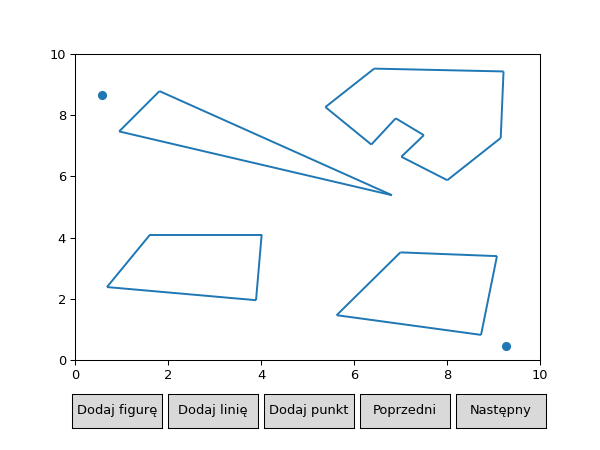

In [17]:
plot1 = Plot(xlim=[0,10], ylim=[0, 10], title=" ")
plot1.draw()

<IPython.core.display.Javascript object>


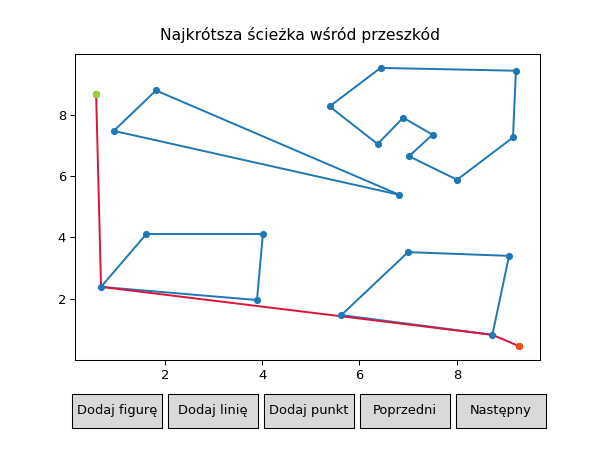

In [18]:
visualisation_plot1 = visualise_shortest_path_among_obstacles(plot1)
visualisation_plot1.draw()

In [115]:
saveToFile(visualisation_plot1, "1")

#### Example 2

<IPython.core.display.Javascript object>


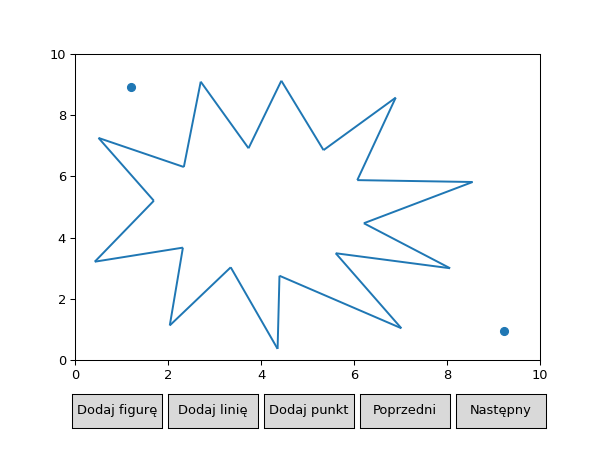

In [30]:
plot2 = Plot(xlim=[0,10], ylim=[0, 10], title=" ")
plot2.draw()

<IPython.core.display.Javascript object>


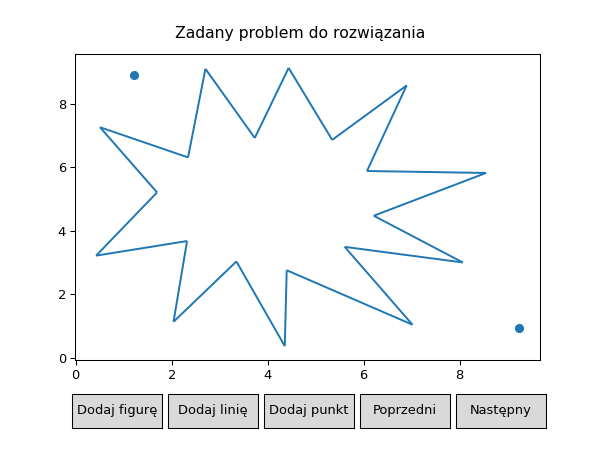

In [31]:
visualisation_plot2 = visualise_shortest_path_among_obstacles(plot2)
visualisation_plot2.draw()

In [116]:
saveToFile(visualisation_plot2, "2")

#### Example 3

<IPython.core.display.Javascript object>


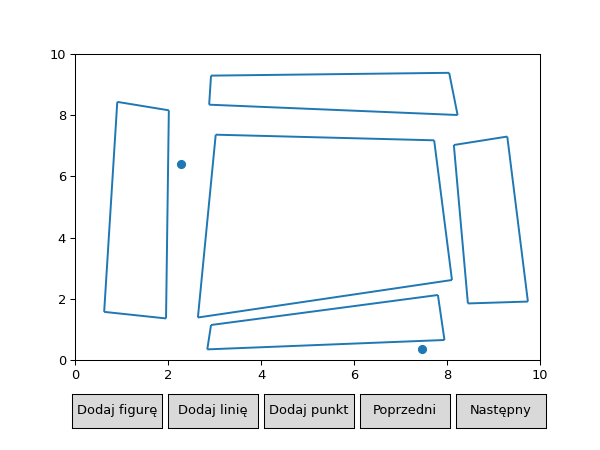

In [33]:
plot3 = Plot(xlim=[0,10], ylim=[0, 10], title=" ")
plot3.draw()

<IPython.core.display.Javascript object>


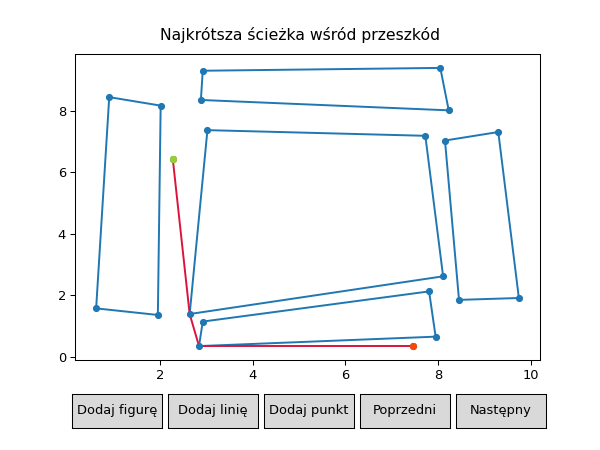

In [34]:
visualisation_plot3 = visualise_shortest_path_among_obstacles(plot3)
visualisation_plot3.draw()

In [117]:
saveToFile(visualisation_plot3, "3")

#### Example 4

<IPython.core.display.Javascript object>


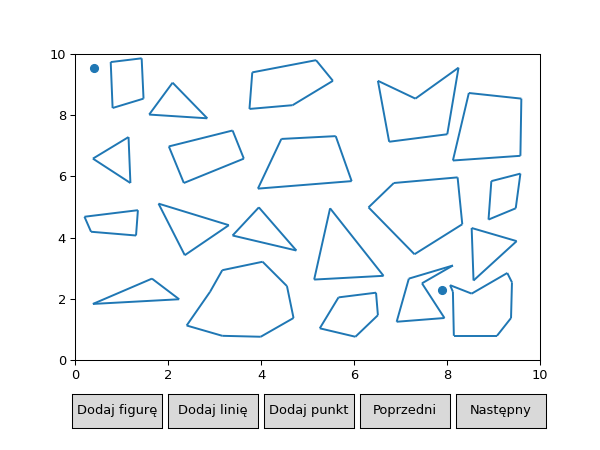

In [37]:
plot4 = Plot(xlim=[0,10], ylim=[0, 10], title=" ")
plot4.draw()

<IPython.core.display.Javascript object>


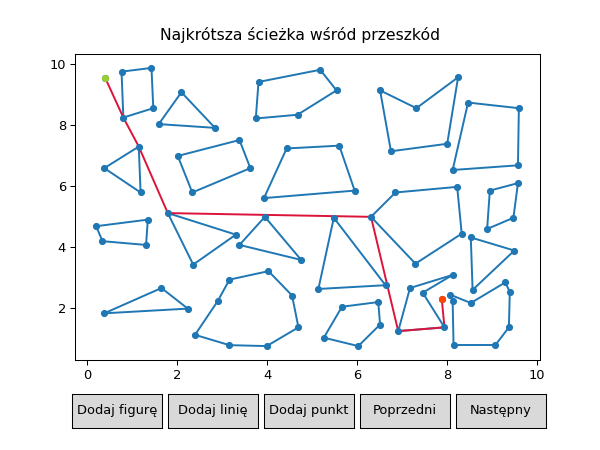

In [38]:
visualisation_plot4 = visualise_shortest_path_among_obstacles(plot4)
visualisation_plot4.draw()

In [71]:
saveToFile(visualisation_plot4, "4")

#### Example 5

<IPython.core.display.Javascript object>


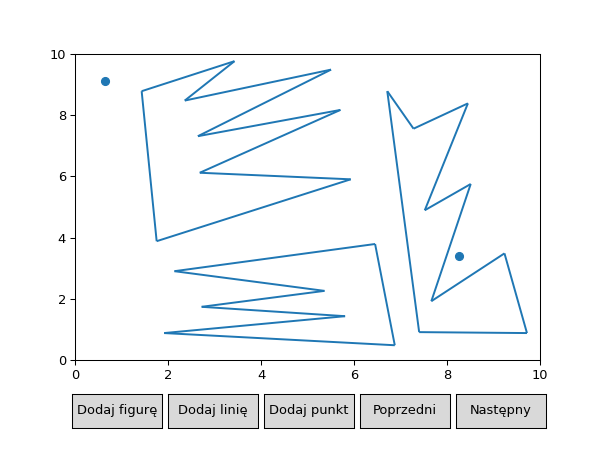

In [40]:
plot5 = Plot(xlim=[0,10], ylim=[0, 10], title=" ")
plot5.draw()

<IPython.core.display.Javascript object>


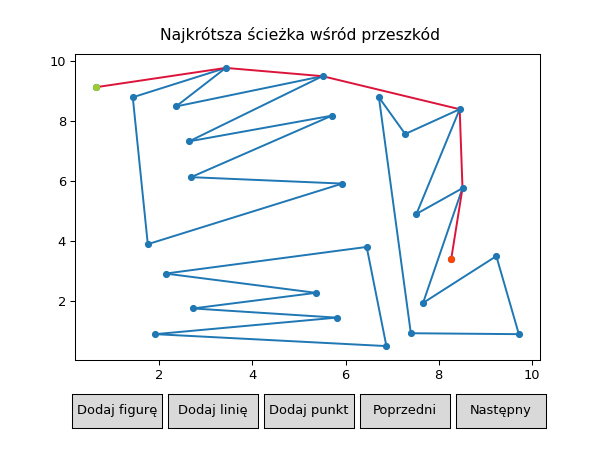

In [41]:
visualisation_plot5 = visualise_shortest_path_among_obstacles(plot5)
visualisation_plot5.draw()

In [118]:
saveToFile(visualisation_plot5, "5")

#### Example 6

<IPython.core.display.Javascript object>


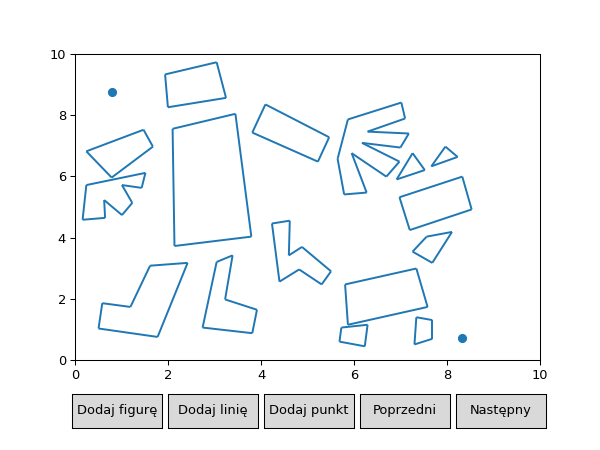

In [44]:
plot6 = Plot(xlim=[0,10], ylim=[0, 10], title=" ")
plot6.draw()

<IPython.core.display.Javascript object>


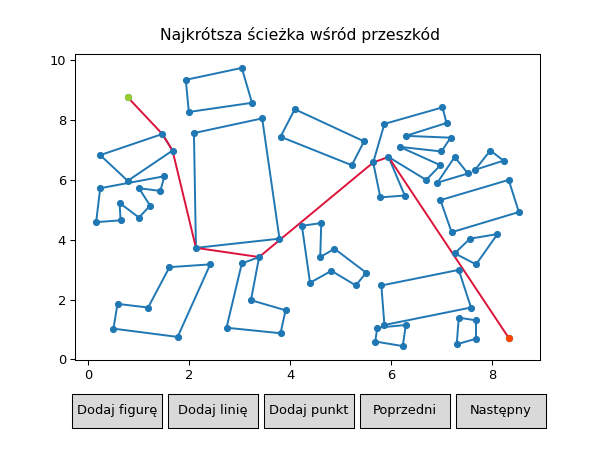

In [45]:
visualisation_plot6 = visualise_shortest_path_among_obstacles(plot6)
visualisation_plot6.draw()

In [73]:
saveToFile(visualisation_plot6, "6")

#### Example 7

<IPython.core.display.Javascript object>


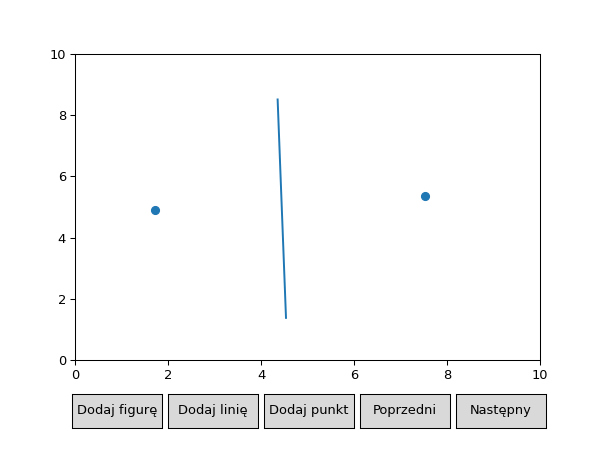

In [50]:
plot7 = Plot(xlim=[0,10], ylim=[0, 10], title=" ")
plot7.draw()

<IPython.core.display.Javascript object>


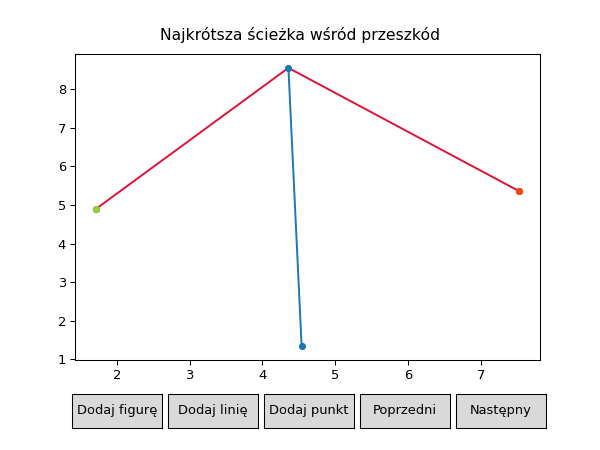

In [51]:
visualisation_plot7 = visualise_shortest_path_among_obstacles(plot7)
visualisation_plot7.draw()

In [119]:
saveToFile(visualisation_plot7, "7")

#### Example 8

<IPython.core.display.Javascript object>


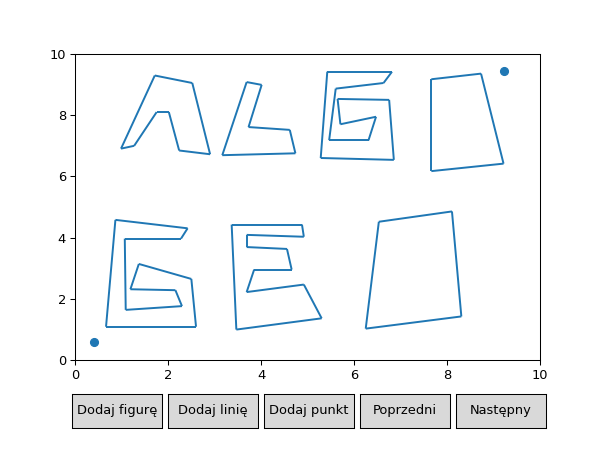

In [56]:
plot8 = Plot(xlim=[0,10], ylim=[0, 10], title=" ")
plot8.draw()

<IPython.core.display.Javascript object>


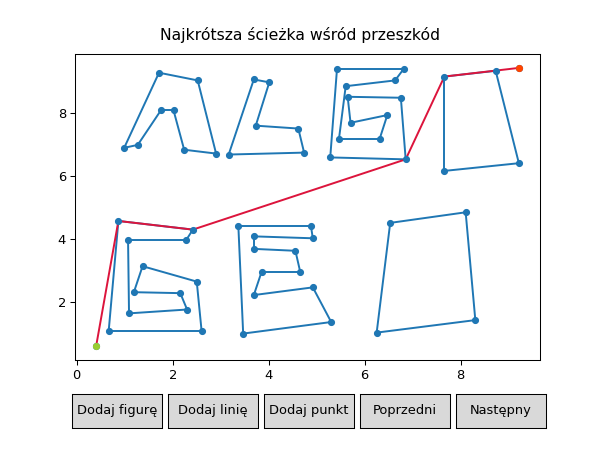

In [57]:
visualisation_plot8 = visualise_shortest_path_among_obstacles(plot8)
visualisation_plot8.draw()

In [75]:
saveToFile(visualisation_plot8, "8")

#### Example 9

<IPython.core.display.Javascript object>


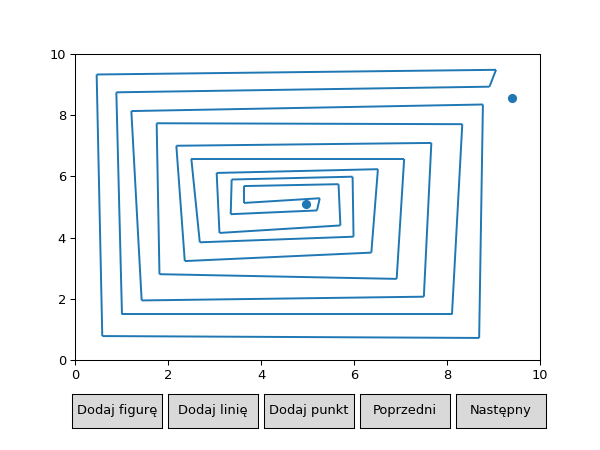

In [60]:
plot9 = Plot(xlim=[0,10], ylim=[0, 10], title=" ")
plot9.draw()

<IPython.core.display.Javascript object>


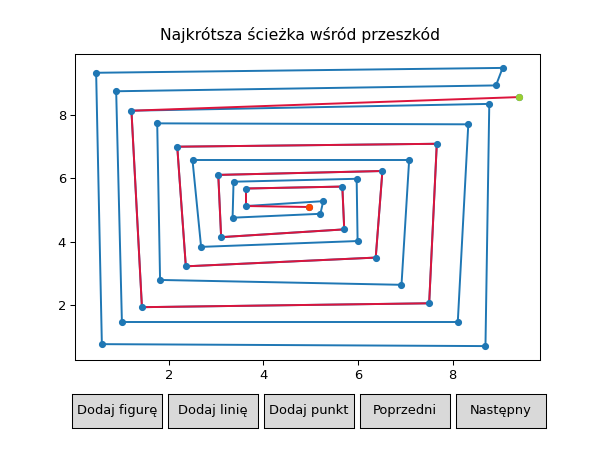

In [62]:
visualisation_plot9 = visualise_shortest_path_among_obstacles(plot9)
visualisation_plot9.draw()

In [120]:
saveToFile(visualisation_plot9, "9")

#### Example 10

<IPython.core.display.Javascript object>


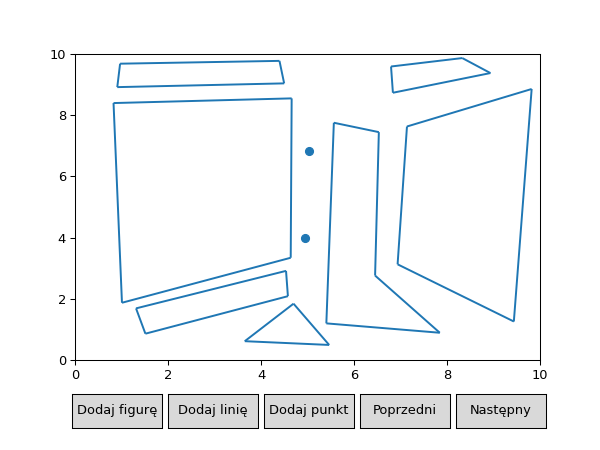

In [65]:
plot10 = Plot(xlim=[0,10], ylim=[0, 10], title=" ")
plot10.draw()

<IPython.core.display.Javascript object>


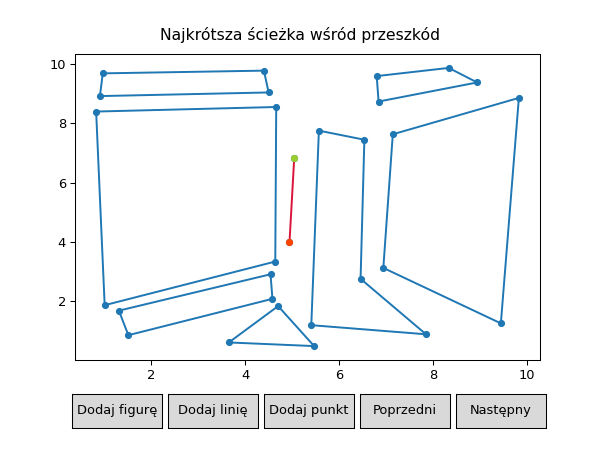

In [66]:
visualisation_plot10 = visualise_shortest_path_among_obstacles(plot10)
visualisation_plot10.draw()

In [121]:
saveToFile(visualisation_plot10, "10")

### Reading from file

<IPython.core.display.Javascript object>


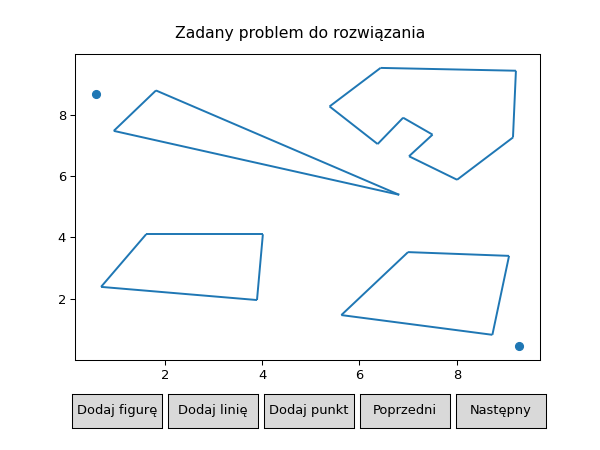

In [80]:
json1 = readFromFile("example1")
plot1 = Plot(json=json1)
plot1.draw()

<IPython.core.display.Javascript object>


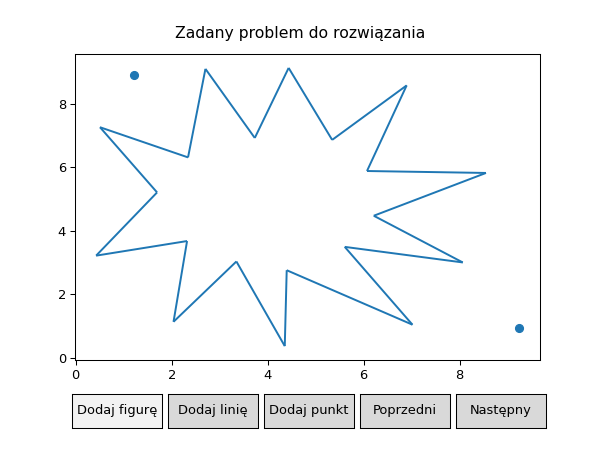

In [81]:
json2 = readFromFile("example2")
plot2 = Plot(json=json2)
plot2.draw()

<IPython.core.display.Javascript object>


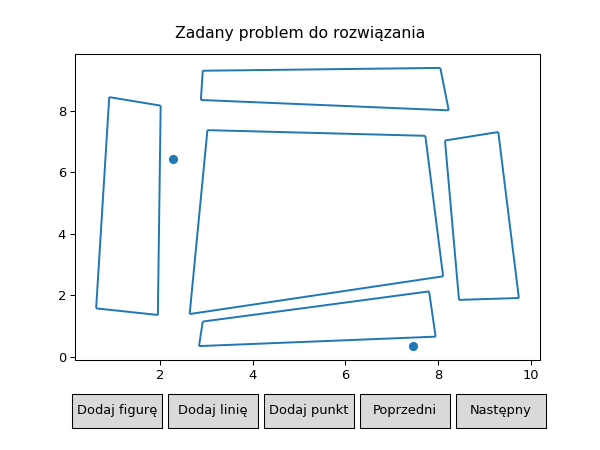

In [83]:
json3 = readFromFile("example3")
plot3 = Plot(json=json3)
plot3.draw()

<IPython.core.display.Javascript object>


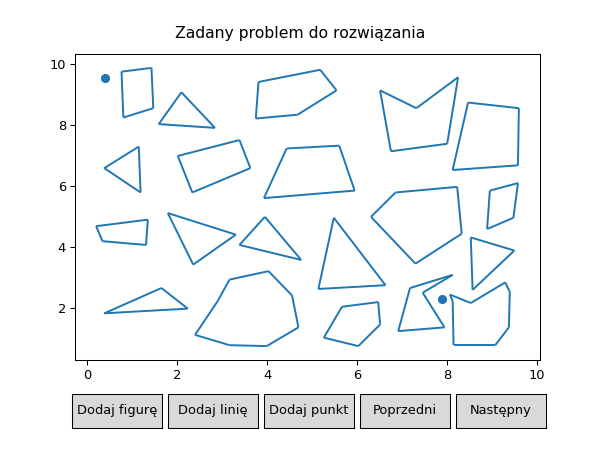

In [97]:
json4 = readFromFile("example4")
plot4 = Plot(json=json4)
plot4.draw()

<IPython.core.display.Javascript object>


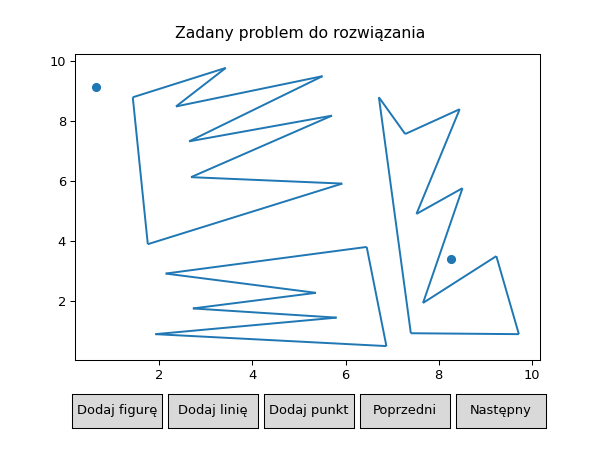

In [102]:
json5 = readFromFile("example5")
plot5 = Plot(json=json5)
plot5.draw()

<IPython.core.display.Javascript object>


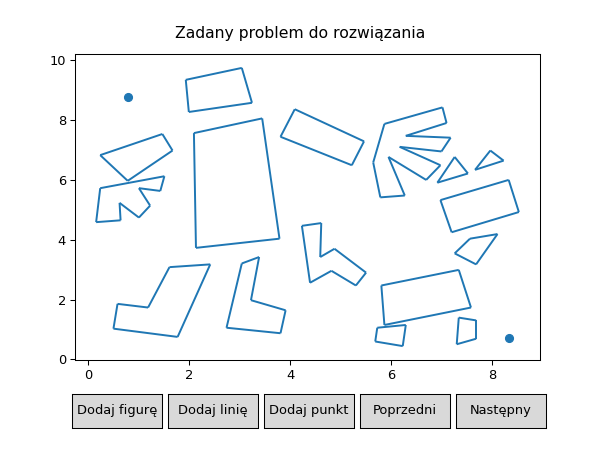

In [103]:
json6 = readFromFile("example6")
plot6 = Plot(json=json6)
plot6.draw()

<IPython.core.display.Javascript object>


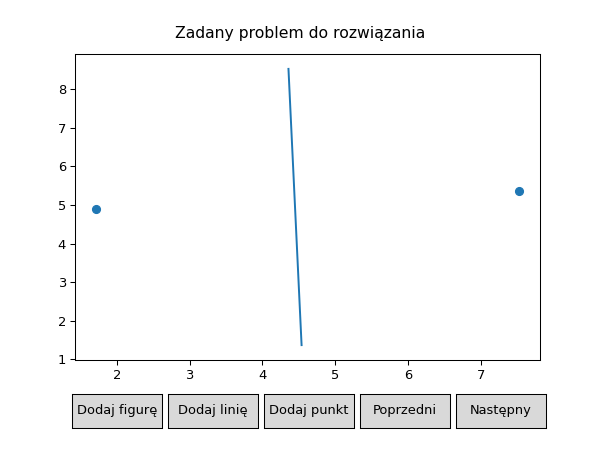

In [104]:
json7 = readFromFile("example7")
plot7 = Plot(json=json7)
plot7.draw()

<IPython.core.display.Javascript object>


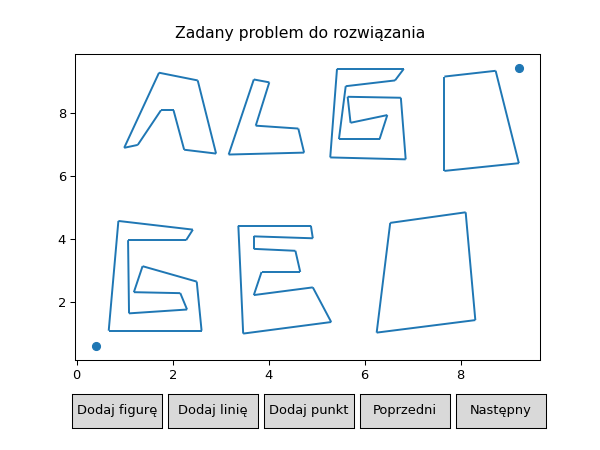

In [105]:
json8 = readFromFile("example8")
plot8 = Plot(json=json8)
plot8.draw()

<IPython.core.display.Javascript object>


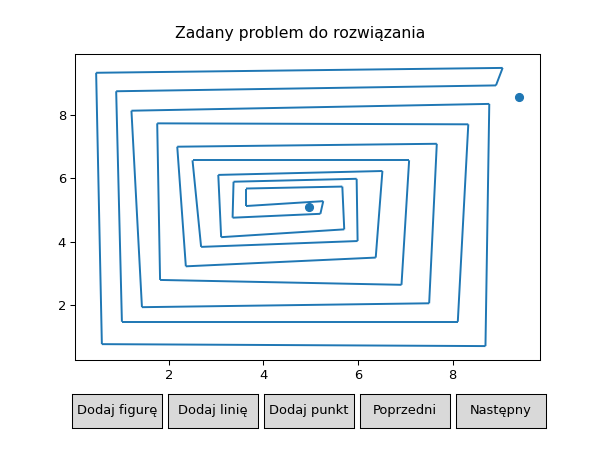

In [78]:
json9 = readFromFile("example9")
plot9 = Plot(json=json9)
plot9.draw()

<IPython.core.display.Javascript object>


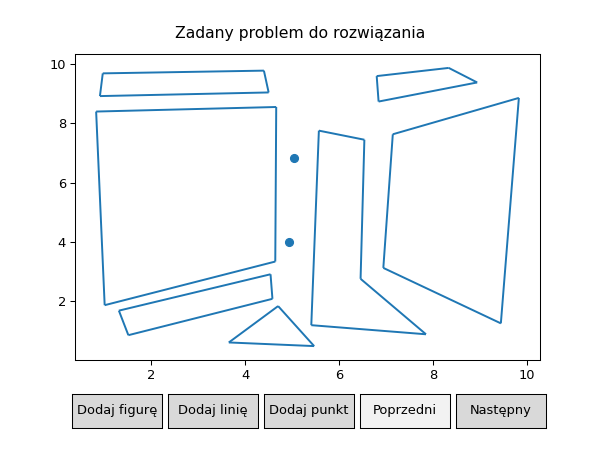

In [79]:
json10 = readFromFile("example10")
plot10 = Plot(json=json10)
plot10.draw()